# PERM Rosenbluth

###### Pruned-enriched Rosenbluth method for the simulations of polymers

In [19]:
"""Import the packages that are used"""
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.spatial

pylab.rcParams['figure.figsize'] = 14, 10  # default image size for this interactive session

## Parameters

In [23]:
"""Define all the parameters nesssesary to peform the MC simulation"""
steps = 1000      # the number of MC steps
N = 150          # number of atoms that is placed
N_theta = 9      # number of thetas that is chosen
N_max = 3*steps  # maximum number of polymers
epsilon = 0.25   # constant for the LJ-potential
sigma = 0.8
sigma6 = sigma**6
sigma12 = sigma**12 # constant for the LJ-potential

bifurcations = np.zeros(N)
prunings = np.zeros(N)

cnt = np.zeros(N, dtype=int)
x_new = np.zeros((N_theta, 2))
x = np.zeros((N, 2))
end2end = np.zeros((N, N_max))
W_array = np.zeros((N, N_max))
x[1, 0] = 1.0  # the second atom at (1, 0)

## Functions

Defining functions for the Lennard-Jones potential: $V(r) = 4{\epsilon}\left[\left({\frac{\sigma}{r}}\right)^{12}-\left({\frac{\sigma}{r}}\right)^6\right]$ and a recursive function $mc(x,\;L,\;W,\;pe)$ that adds a bead to the polymer.

In [24]:
def mc(x, L, W, pe):
    """Perform an MC step.

    Parameters:
    -----------
    x : polymer
    L : length
    W : weight
    pe : Pruned-Enriched Rosenbluth Boolean True or False
    """
    # generate an equally spaced vector with intevals of 2pi/N_theta + a
    # random off-set
    theta = 2 * np.pi * np.random.rand() + np.linspace(0, 2 * np.pi, N_theta)

    # the positions of the new atom that is placed
    x_new[:, 0] = x[L, 0] + np.cos(theta)
    x_new[:, 1] = x[L, 1] + np.sin(theta)

    # calculate the weights of the new positions
    w = np.exp(-E(x, x_new, L))
    w_sum = np.sum(w)
    W *= w_sum / (0.75 * N_theta)

    # choose a theta with a roulette wheel algoritm, this gives the index
    theta_idx = np.digitize(w_sum * np.random.rand(1), np.cumsum(w))
    if theta_idx == 9:
        # if all the weights are zero, chose a random theta
        theta_idx = np.random.randint(0, 8)

    # place the next atom at the theta that was found
    x[L + 1] = x_new[theta_idx]

    # calculate the end to end distance
    end2end_abs = x[0] - x[L + 1]
    end2end[L + 1, cnt[L + 1]] = np.sum(end2end_abs**2)

    # put the weight in an array
    W_array[L + 1, cnt[L + 1]] = W
    W_sum = np.sum(W_array[L + 1, :cnt[L + 1]])
    W_0 = np.sum(W_array[2, :cnt[2]])  # weight of the first few walkers

    # set the upper and lower limit
    up = 2.0 * W_sum / W_0
    low = 1.2 * W_sum / W_0
    W_new = W

    cnt[L + 1] += 1

    # Pruned-enriched Rosenbluth
    if pe:
        if cnt[L + 1] > N_max - 2 and L < N - 2:
            mc(x, L + 1, W_new, pe)
        elif L < N - 2:
            if W > up:  # Enrich
                bifurcations[L] += 1
                W_new = W * 0.5
                mc(x, L + 1, W_new, pe)   # clone 1
                W_new = W * 0.5
                mc(x, L + 1, W_new, pe)   # clone 2
            elif W < low:  # Prune
                if np.random.rand(1) < 0.5:  # kill it with 50% chance
                    W_new = 2 * W
                    mc(x, L + 1, W_new, pe)
                    prunings[L] += 1
            else:
                mc(x, L + 1, W_new, pe)
    # Normal Rosenbluth
    else:
        if L < N - 2:
            mc(x, L + 1, W_new, pe)


def E(x, x_new, L):
    """ The lennnard-Jones potential.

    Parameters:
    -----------
    x : polymer
    x_new : 9 new proposed positions for theta
    L : length
    """
    r = scipy.spatial.distance.cdist(x[:L], x_new, 'euclidean')
    return np.sum(4 * epsilon * (sigma12 / r**12 - sigma6 / r**6), axis=0)


## Simulation

In [25]:
W = 1
pe = True # Pruned-Enriched on (True) or off (False)
for i in range(steps):
    mc(x, 1, 1, pe)

/home/bnijholt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in double_scalars
/home/bnijholt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in double_scalars


## Data analysis and plotting

First I make the end to end lengths of the polymers a weighted average in which I use the weights of the polymers.

In [26]:
end_to_end_avg = np.average(end2end[2:], weights=W_array[2:], axis=1)
end_to_end_var = np.average(end2end[2:]**2, weights=W_array[2:], axis=1) - end_to_end_avg**2
end_to_end_error = np.sqrt(end_to_end_var/steps)

Now I am going to plot the end to end distance a function of polymer length and fit an exponential curve to it of the form $a(N-1)^b$ in which $b$ should be equal to 1.5. I make a plot with both $a$ and $b$ as fit parameters, and one in which I only fot $a$. Note that the errors given in the titles ($\sigma_a^2$ and $\sigma_b^2$) are fit-errors. The error in the simulations are plotted with the errorbars, which are barely visible, but gets bigger with larger polymers.

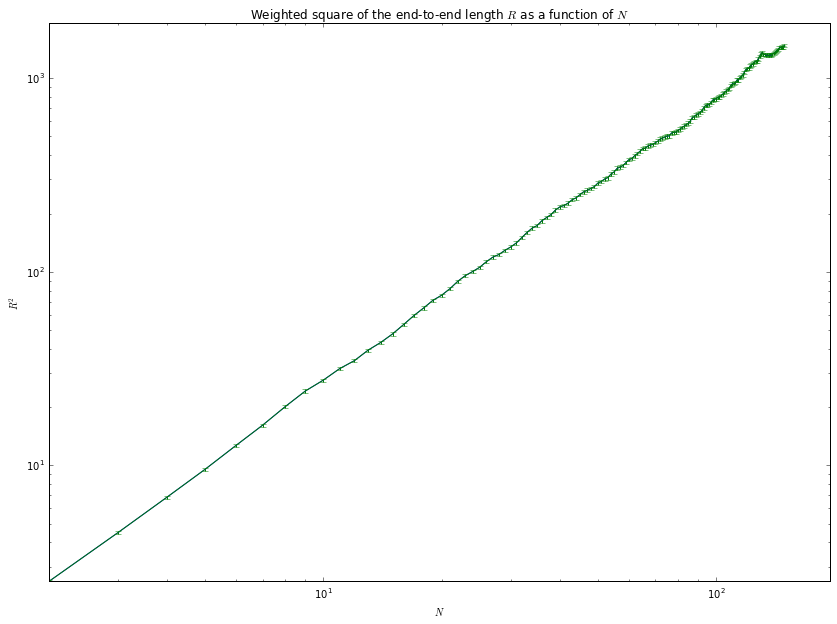

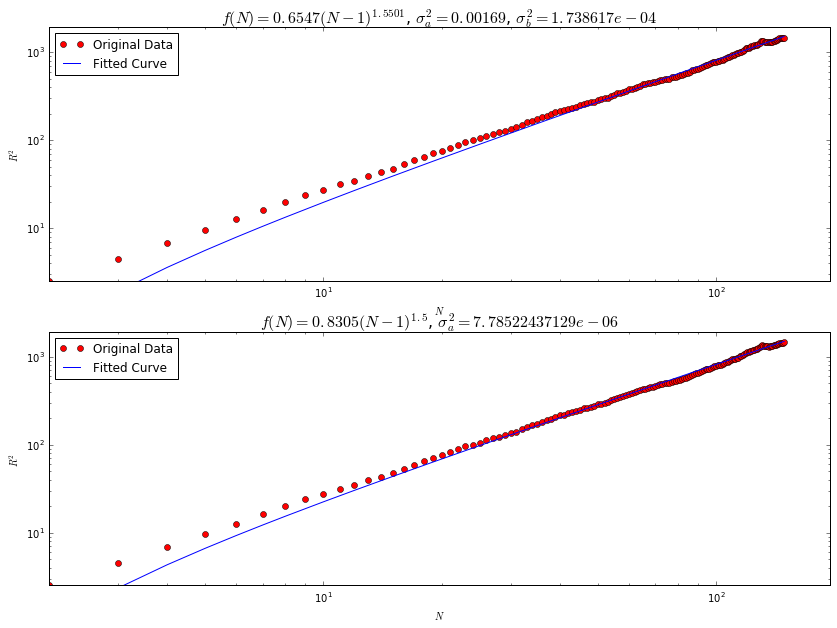

In [28]:
""" Fit an exponential curve ( a*(N-1)**0.75 ) to the data and find the coefficient a"""
from scipy.optimize import curve_fit

def func(N, a, b):
    return a*(N-1)**b

def func2(N, a):
    return a*(N-1)**1.5

xx = np.arange(2, N)
yy = end_to_end_avg

popt, pcov = curve_fit(func, xx, yy)    # fit for a*(N-1)**b
popt2, pcov2 = curve_fit(func2, xx, yy) # fit for a*(N-1)**1.5

plt.title(r'Weighted square of the end-to-end length $R$ as a function of $N$', )
plt.plot(xx, yy)
plt.errorbar(xx, yy, end_to_end_error)
plt.xlabel(r'$N$')
plt.ylabel(r'$R^2$')
plt.xlim(2,N*1.3)
plt.ylim(yy[0],yy[N-3]*1.3)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

plt.subplot(211)
plt.title(r'$f(N)= %s(N-1)^{%s}$, $\sigma_a^2= %s$, $\sigma_b^2=%e$' %(round(popt[0],4), 
                                                                       round(popt[1],4), 
                                                                       round(pcov.diagonal()[0],6), 
                                                                       pcov.diagonal()[1]), fontsize=16)
plt.plot(xx, yy, 'ro',label="Original Data")
plt.plot(xx, func(xx, *popt), label="Fitted Curve")
plt.xlabel(r'$N$')
plt.ylabel(r'$R^2$')
plt.xlim(2,N*1.3)
plt.ylim(yy[0],yy[N-3]*1.3)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc='upper left')

plt.subplot(212)
plt.title(r'$f(N)= %s(N-1)^{1.5}$, $\sigma_a^2= %s$' %(round(popt2[0],4), pcov2.diagonal()[0]), fontsize=16)
plt.plot(xx, yy, 'ro',label="Original Data")
plt.plot(xx, func2(xx, *popt2), label="Fitted Curve")
plt.xlabel(r'$N$')
plt.ylabel(r'$R^2$')
plt.xlim(2,N*1.3)
plt.ylim(yy[0],yy[N-3]*1.3)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc='upper left')
plt.show()

## Other plots

The last polymer in the simulation and some other plots used for checking the pruning strategy. 

The plot of the polymer might not look like a realistic polymer at all, but that is because x array is not overwritten and each time the x array is filled up to $x[1:L]$ in which $L$ is it's length after which it is killed, so the values above L ($x[L+1:end]$) are values from previous realisations of polymers. Note that if one would run the script without enrichment and pruning, a full polymer would be generated.

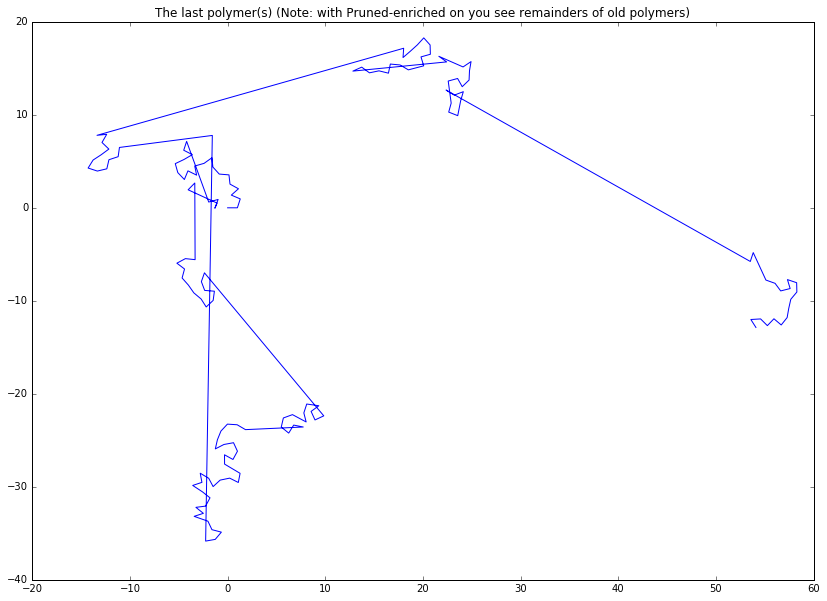

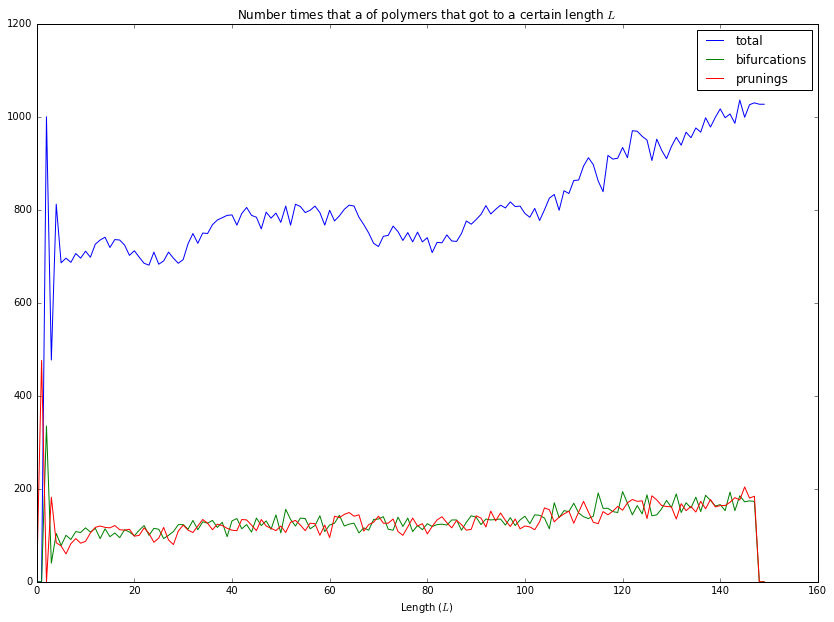

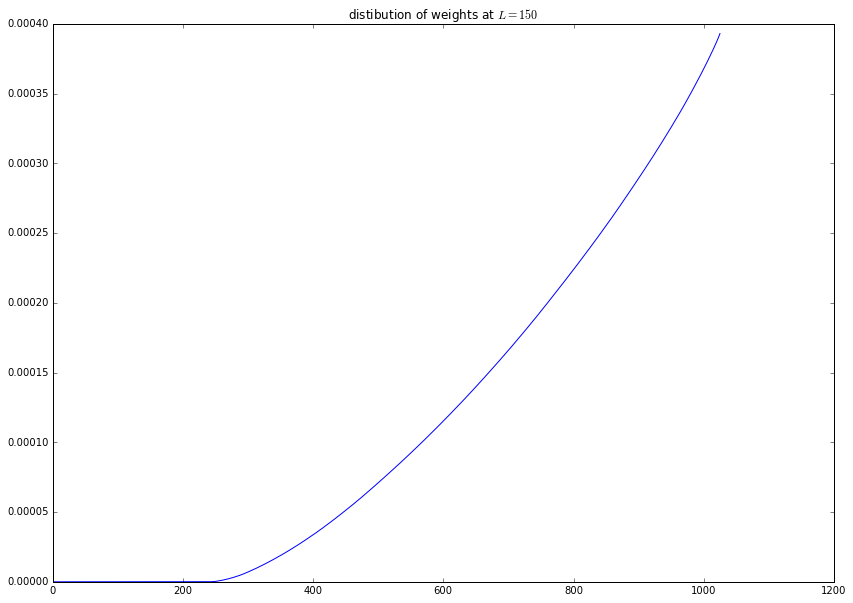

In [30]:
# plot the last polymer
plt.title('The last polymer(s) (Note: with Pruned-enriched on you see remainders of old polymers)')
plt.plot(x[:,0],x[:,1], label='last polymer')
plt.show()
r = np.sum(x**2, axis=1)
abs(r[:N-1]-r[1:])

plt.title('Number times that a of polymers that got to a certain length $L$')
plt.plot(cnt, label='total')
plt.plot(bifurcations, label='bifurcations')
plt.plot(prunings, label='prunings')
plt.xlabel('Length ($L$)')
plt.legend()
plt.show()

def weight_distribution(L):
    a = W_array[L].copy()
    a = np.sort(a[a.nonzero()])
    return np.cumsum(a)

plt.plot(weight_distribution(149))
plt.title(r'distibution of weights at $L=150$')
plt.show()